In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [89]:
# load dataset (note that dataset is seperated by ';' rather than usual ',')
# Set Date as index column and 
data = pd.read_csv('WindData.csv', sep = ';', index_col= 'Date', parse_dates=True, date_format="%d/%m/%Y %H:%M")
data


,Wind Production PZ_1,Wind Production PZ_2,Station1_WND,Station1_DD,Station2_WND,Station2_DD,Station3_WND,Station3_DD,Station4_WND,Station4_DD,...,Station8_WND,Station8_DD,Station9_WND,Station9_DD,Station10_WND,Station10_DD,Station11_WND,Station11_DD,Station12_WND,Station12_DD
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,"1396,847852","122,7055319","9,6",191,"6,1",179,7,224,"8,4",198,...,"12,4",199,"7,7",228,"6,1",195,"5,7",184,"10,2",202
2016-01-01 01:00:00,"1304,469541","105,1476672","9,8",188,"6,1",177,"6,6",227,"8,3",192,...,"13,2",197,"7,3",231,6,193,"5,3",185,"10,7",200
2016-01-01 02:00:00,"1201,416846","80,806082","9,9",188,"6,6",174,"6,3",231,"8,3",183,...,"13,4",197,"6,9",235,"6,3",193,"5,3",188,"10,4",199
2016-01-01 03:00:00,"1198,324268","67,63768345",10,187,"7,1",172,6,234,"8,4",173,...,"13,6",197,"6,6",239,"6,7",193,"5,2",191,"10,1",197
2016-01-01 04:00:00,"1113,926804","51,57622764","9,8",188,"7,5",172,"6,1",232,"8,5",171,...,13,202,"6,4",237,7,193,"4,8",195,"9,7",197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,"3049,62372","843,204789","12,7",250,"12,5",249,"13,1",244,"12,9",248,...,"14,5",255,"14,2",239,"12,1",251,"10,9",254,11,244
2016-12-31 20:00:00,"3045,754898","848,66082","12,7",250,"12,2",248,13,244,"12,7",247,...,"14,8",253,"14,1",240,12,250,"10,9",253,"11,4",245
2016-12-31 21:00:00,"3091,585559","845,4864019","12,8",249,12,247,13,244,"12,6",246,...,"15,2",252,"14,1",241,"11,9",248,11,252,"11,8",246


### Key points about the dataset
- Actual production for two regions (MW)  =  (Wind Production PZ_1, Wind Production PZ_2) columns
- forecasted wind speed (m/s) = WND columns
- forecasted wind direction (degrees) = DD columns


In [90]:
# check data types are correct
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Wind Production PZ_1  8784 non-null   object
 1   Wind Production PZ_2  8784 non-null   object
 2   Station1_WND          8784 non-null   object
 3   Station1_DD           8784 non-null   int64 
 4   Station2_WND          8784 non-null   object
 5   Station2_DD           8784 non-null   object
 6   Station3_WND          8784 non-null   object
 7   Station3_DD           8784 non-null   object
 8   Station4_WND          8784 non-null   object
 9   Station4_DD           8784 non-null   object
 10  Station5_WND          8784 non-null   object
 11  Station5_DD           8784 non-null   int64 
 12  Station6_WND          8784 non-null   object
 13  Station6_DD           8784 non-null   int64 
 14  Station7_WND          8784 non-null   object
 15  St

In [91]:
# Clean up data columns
# convert columns to numeric data types + commas causing a problem with Wind Production columns

wind_production_columns = ['Wind Production PZ_1', 'Wind Production PZ_2']
station_columns = [f'Station{i}_DD' for i in range(1, 13)] + [f'Station{i}_WND' for i in range(1, 13)]

for col in wind_production_columns + station_columns:
    if data[col].dtype == 'object':  # Check if the column is of string type
        data[col] = data[col].str.replace(',', '.')
        data[col] = pd.to_numeric(data[col], errors='coerce')


In [92]:
# check for null values
data.isnull().sum()

Wind Production PZ_1    0
Wind Production PZ_2    0
Station1_WND            0
Station1_DD             0
Station2_WND            0
Station2_DD             0
Station3_WND            0
Station3_DD             0
Station4_WND            0
Station4_DD             0
Station5_WND            0
Station5_DD             0
Station6_WND            0
Station6_DD             0
Station7_WND            0
Station7_DD             0
Station8_WND            0
Station8_DD             0
Station9_WND            0
Station9_DD             0
Station10_WND           0
Station10_DD            0
Station11_WND           0
Station11_DD            0
Station12_WND           0
Station12_DD            0
dtype: int64

In [93]:
# number of null values low so drop rows containing null values
data = data.dropna()


Now data has been cleaned it is time to explore/visualise data

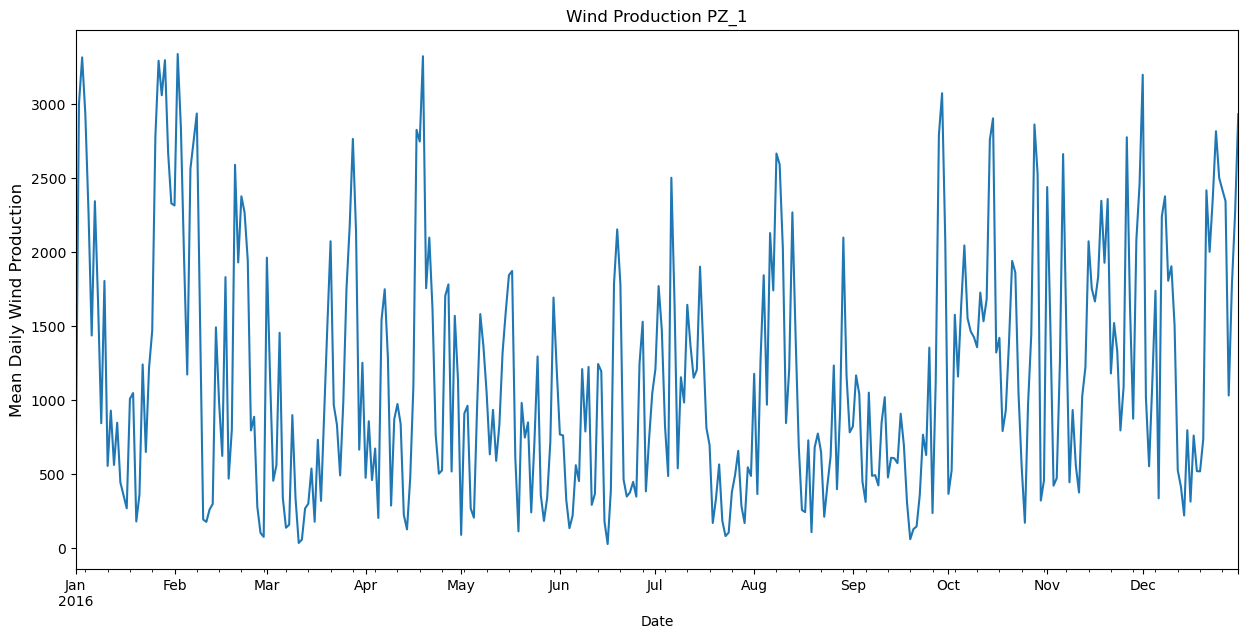

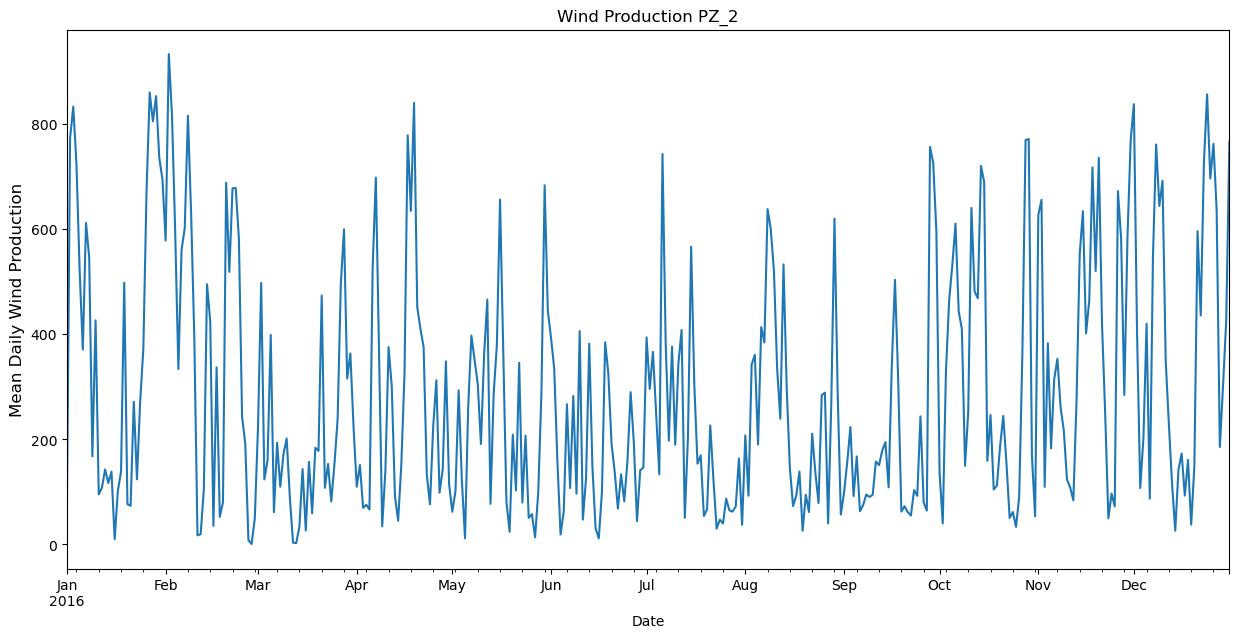

In [94]:
# Resampling daily 
plt.figure(figsize=(15,7))
plt.title('Wind Production PZ_1')
data['Wind Production PZ_1'].resample('D').mean().plot()
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.show()

plt.figure(figsize=(15,7))
plt.title('Wind Production PZ_2')
data['Wind Production PZ_2'].resample('D').mean().plot()
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.show()


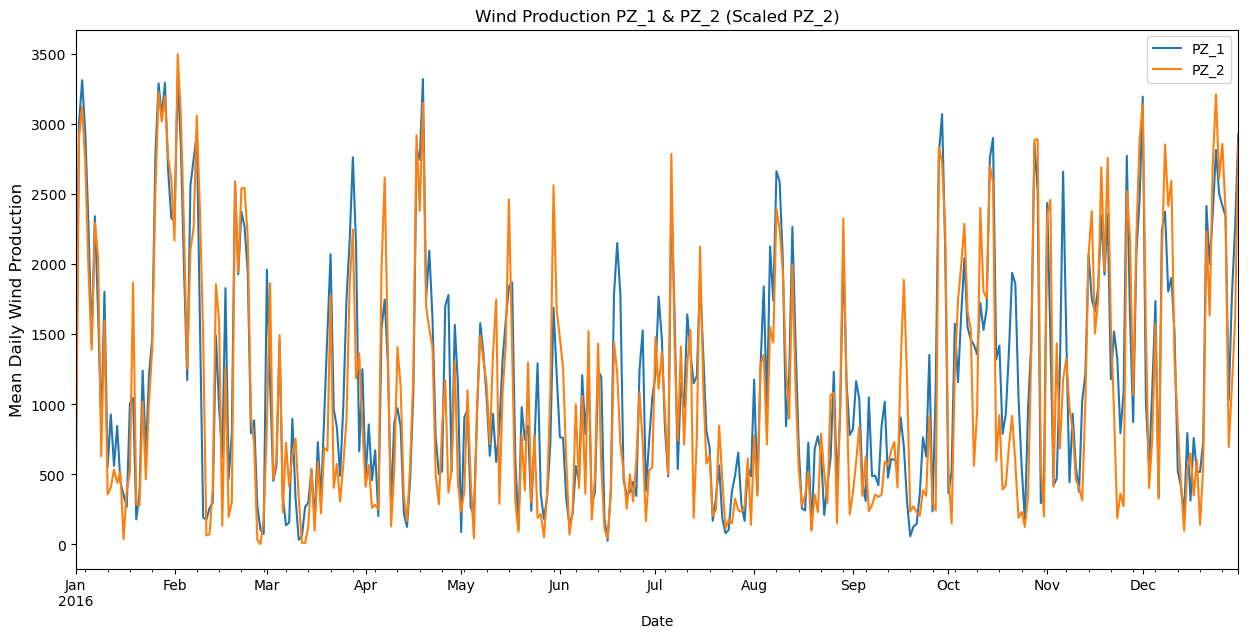

In [64]:
# plot combined with scaling
plt.figure(figsize=(15,7))
plt.title('Wind Production PZ_1 & PZ_2 (Scaled PZ_2)')
data['Wind Production PZ_1'].resample('D').mean().plot(label='PZ_1')
(data['Wind Production PZ_2']*3.75).resample('D').mean().plot(label='PZ_2')
plt.legend()
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.show()


It is worth noting that the wind production from the two zones follow a very similar trend up to scaling.

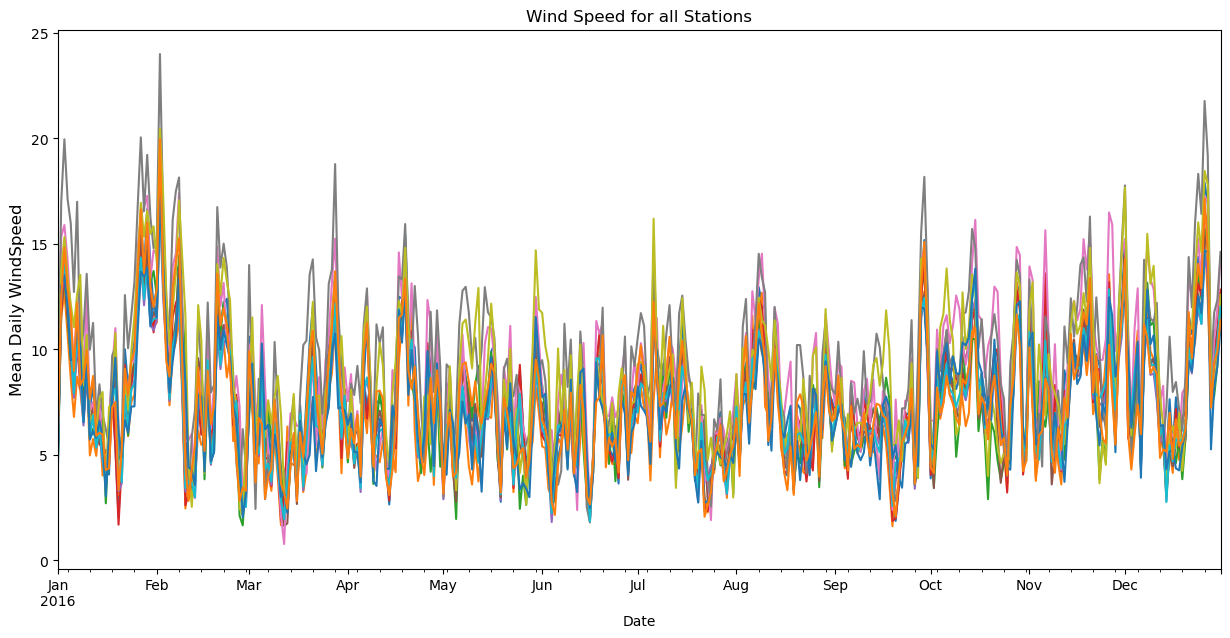

In [65]:
# plot speed for all stations
plt.figure(figsize=(15,7))
plt.title('Wind Speed for all Stations')
for i in range(1,13):
    data[f'Station{i}_WND'].resample('D').mean().plot()
plt.ylabel('Mean Daily WindSpeed', fontsize = 12)
plt.show()

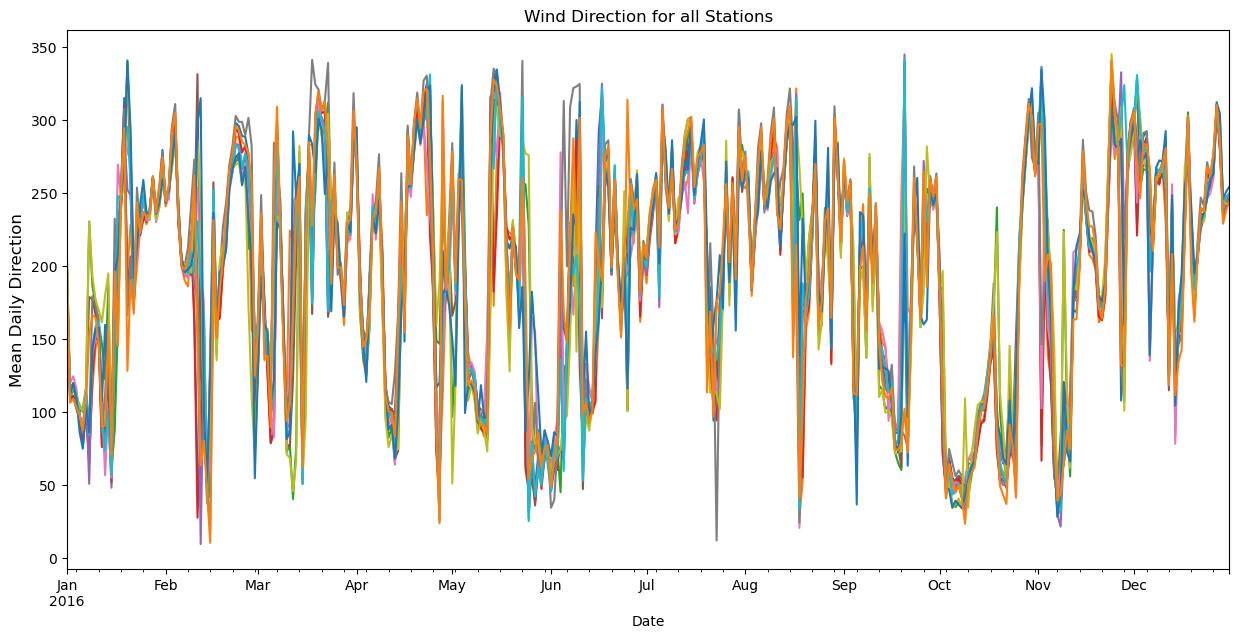

In [66]:
# plot direction for all stations
plt.figure(figsize=(15,7))
plt.title('Wind Direction for all Stations')
for i in range(1,13):
    data[f'Station{i}_DD'].resample('D').mean().plot()
plt.ylabel('Mean Daily Direction', fontsize = 12)
plt.show()

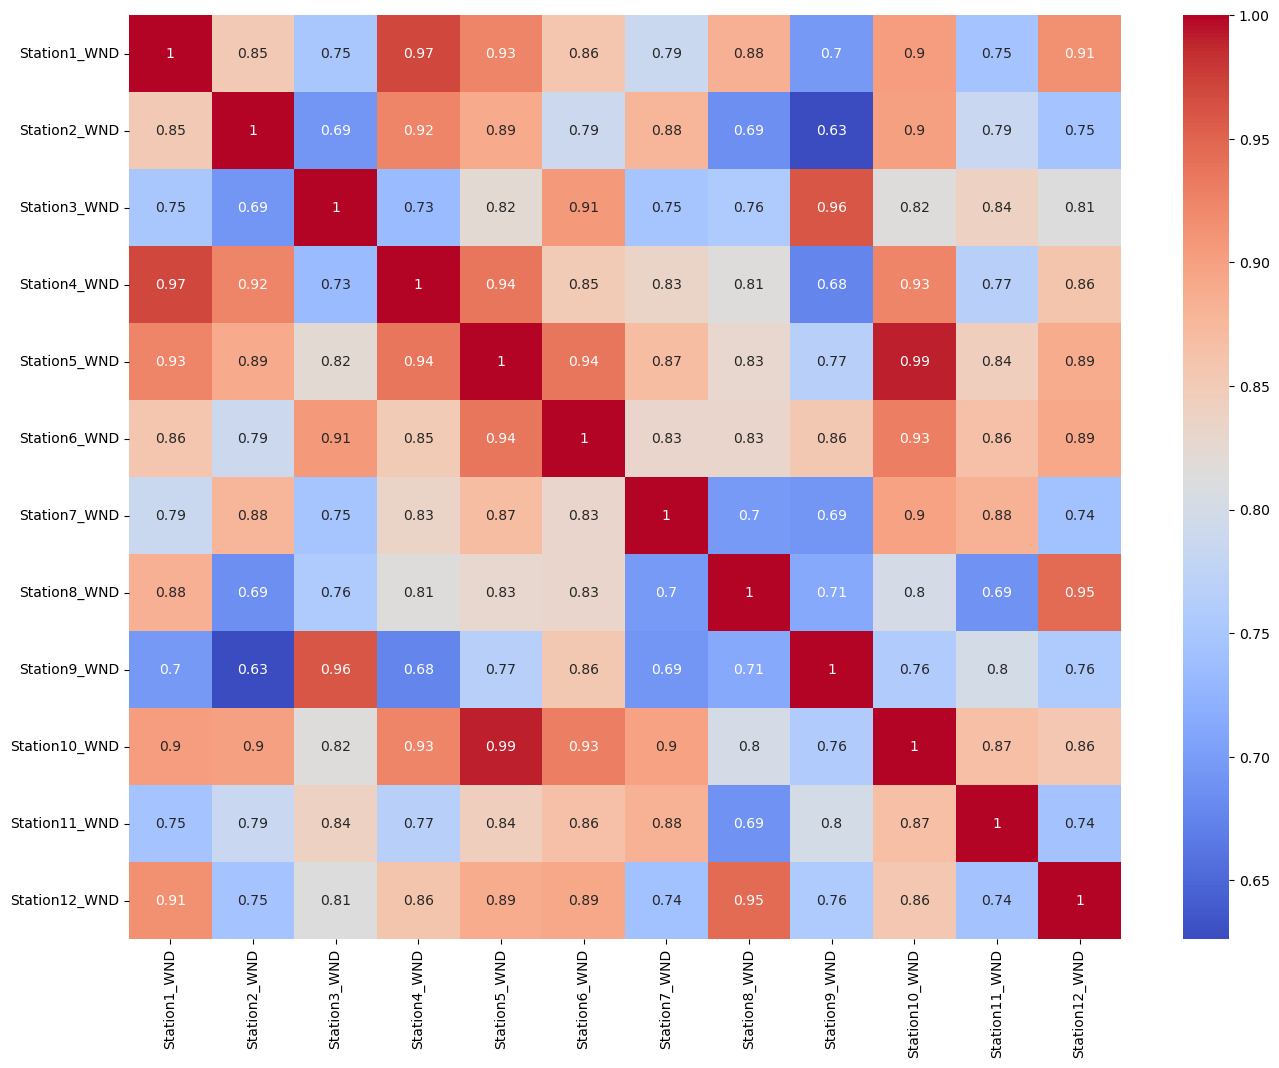

In [67]:
# Visualise correlation matrix
correlations = data[['Station1_WND','Station2_WND','Station3_WND','Station4_WND',
                     'Station5_WND','Station6_WND','Station7_WND','Station8_WND',
                     'Station9_WND','Station10_WND','Station11_WND','Station12_WND']].corr(method='pearson')
plt.figure(figsize = (16,12))
sns.heatmap(correlations, cmap='coolwarm', annot=True)
plt.show()

### Create the model to predict wind production in region 2

In [68]:
# set features to x and target column to y
x = data.drop(['Wind Production PZ_1','Wind Production PZ_2'], axis=1)
y = data['Wind Production PZ_2']

# split into training and testing data
xtrain,xtest,ytrain,ytest = train_test_split(
    x,y,test_size=0.2, shuffle=False
    )

model = RandomForestRegressor()
model.fit(xtrain,ytrain)


KeyboardInterrupt: 

In [ ]:
predict_train = model.predict(xtrain)
predict_test = model.predict(xtest)

rmse = mean_squared_error(ytrain, predict_train, squared=False)
r2 = r2_score(ytrain, predict_train)
print("---Train Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

mae = mean_absolute_error(ytest, predict_test)
rmse = mean_squared_error(ytest, predict_test, squared=False)
r2 = r2_score(ytest, predict_test)
print("---Test Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

---Train Data---
Root Mean Squared Error: 16.950794540729913
R-squared: 0.9952412968873584
---Test Data---
Root Mean Squared Error: 77.34656453508012
R-squared: 0.9273603721762196


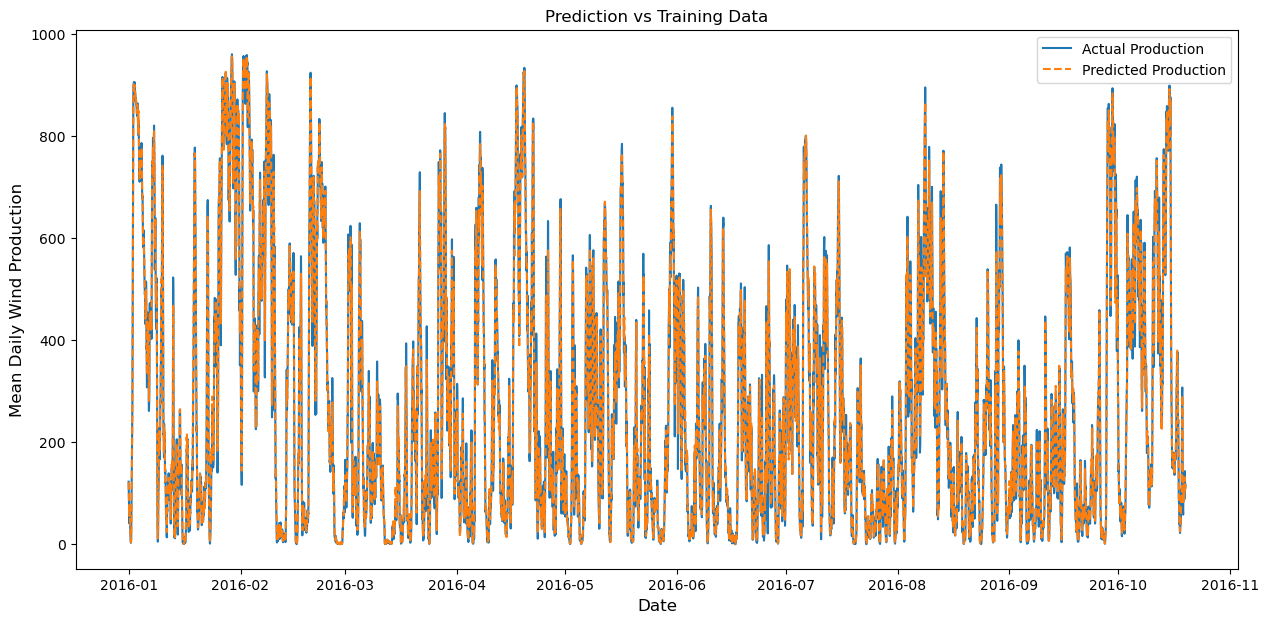

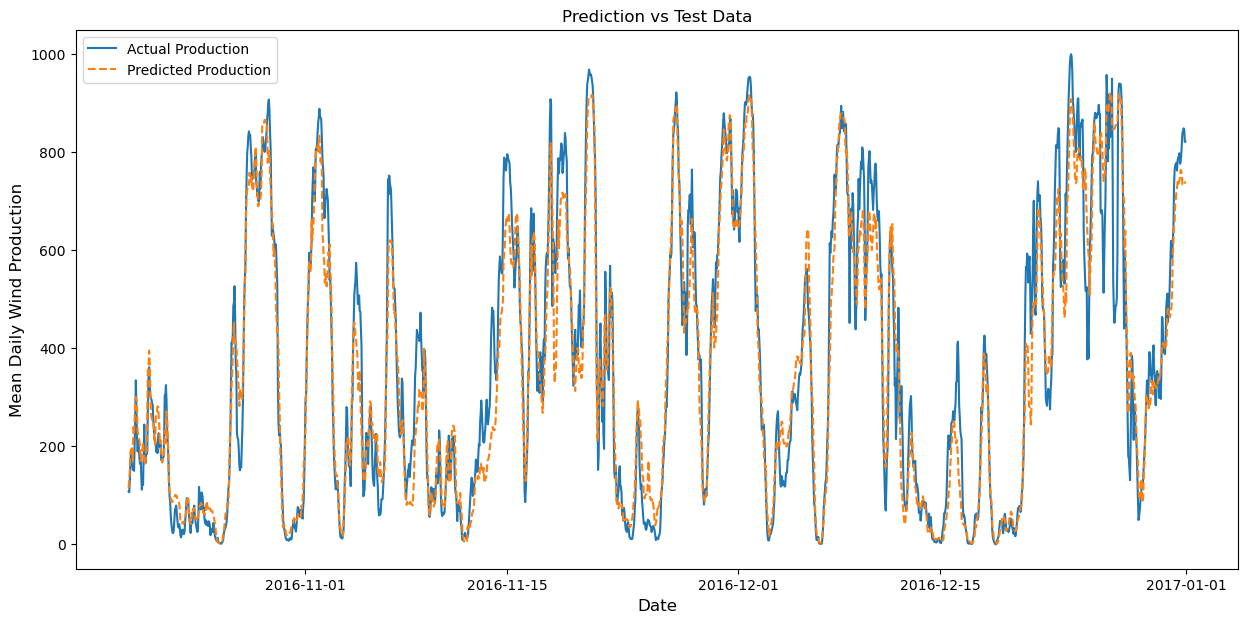

In [ ]:
# Plot comparison between the predictions in training and testing
plt.figure(figsize=(15,7))
plt.title('Prediction vs Training Data')
plt.plot(ytrain,label='Actual Production')
plt.plot(ytrain.index, predict_train, label= 'Predicted Production', linestyle = 'dashed')
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.title('Prediction vs Test Data')
plt.plot(ytest,label='Actual Production')
plt.plot(ytest.index, predict_test, label= 'Predicted Production', linestyle = 'dashed')
plt.ylabel('Mean Daily Wind Production', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.legend()
plt.show()


Now Try to improve the Random Forest Regressor Model

In [ ]:
# try changing random_state

model = RandomForestRegressor(n_estimators=25, random_state=160, max_depth=None)
model.fit(xtrain,ytrain)

RandomForestRegressor(n_estimators=25, random_state=160)

In [ ]:
predict_train = model.predict(xtrain)
predict_test = model.predict(xtest)

rmse = mean_squared_error(ytrain, predict_train, squared=False)
r2 = r2_score(ytrain, predict_train)
print("---Train Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

rmse = mean_squared_error(ytest, predict_test, squared=False)
r2 = r2_score(ytest, predict_test)
print("---Test Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

---Train Data---
Root Mean Squared Error: 18.601313669935557
R-squared: 0.9942694576884307
---Test Data---
Root Mean Squared Error: 77.92308762867594
R-squared: 0.9262734590299424


### Model with tuned hyperparameters

In [ ]:
# split into training and testing data
xtrain,xtest,ytrain,ytest = train_test_split(
    x,y,test_size=0.2, shuffle=True
    )

model = RandomForestRegressor(n_estimators=100, random_state=200, max_depth=None)
model.fit(xtrain,ytrain)

RandomForestRegressor(random_state=200)

In [ ]:
predict_train = model.predict(xtrain)
predict_test = model.predict(xtest)

rmse = mean_squared_error(ytrain, predict_train, squared=False)
r2 = r2_score(ytrain, predict_train)
print("---Train Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

rmse = mean_squared_error(ytest, predict_test, squared=False)
r2 = r2_score(ytest, predict_test)
print("---Test Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

---Train Data---
Root Mean Squared Error: 18.39141850403865
R-squared: 0.9948951178013312
---Test Data---
Root Mean Squared Error: 50.45105013108895
R-squared: 0.9619755258196333


### Now for Wind Production PZ_1

In [ ]:
# set features to x and target column to y
x1 = data.drop(['Wind Production PZ_1','Wind Production PZ_2'], axis=1)
y1 = data['Wind Production PZ_1']

# split into training and testing data
xtrain,xtest,ytrain,ytest = train_test_split(
    x1,y1,test_size=0.2, shuffle=True
    )

model = RandomForestRegressor(n_estimators=100, random_state=200, max_depth=None)
model.fit(xtrain,ytrain)

RandomForestRegressor(random_state=200)

In [ ]:
predict_train = model.predict(xtrain)
predict_test = model.predict(xtest)

rmse = mean_squared_error(ytrain, predict_train, squared=False)
r2 = r2_score(ytrain, predict_train)
print("---Train Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

rmse = mean_squared_error(ytest, predict_test, squared=False)
r2 = r2_score(ytest, predict_test)
print("---Test Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

---Train Data---
Root Mean Squared Error: 52.304667980174074
R-squared: 0.9967181792772484
---Test Data---
Root Mean Squared Error: 147.94626479985263
R-squared: 0.9724330677808981


### Transformed Wind direction

In [ ]:
# Transform wind direction using cos function
for i in range(1,13):
    data[f'Station{i}_DD'] = np.cos(data[f'Station{i}_DD']) 

C:\Users\cnata\AppData\Local\Temp\ipykernel_7024\639941256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Station{i}_DD'] = np.cos(data[f'Station{i}_DD'])


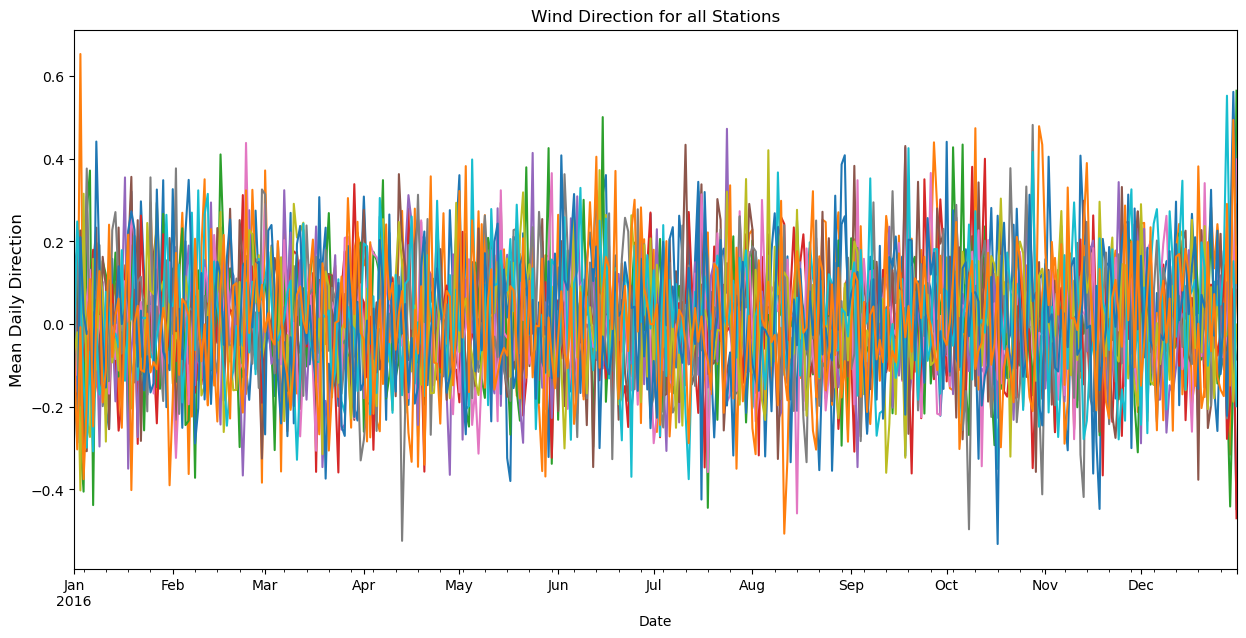

In [ ]:
# plot direction for all stations
plt.figure(figsize=(15,7))
plt.title('Wind Direction for all Stations')
for i in range(1,13):
    data[f'Station{i}_DD'].resample('D').mean().plot()
plt.ylabel('Mean Daily Direction', fontsize = 12)
plt.show()

In [ ]:
# set features to x and target column to y
x = data.drop(['Wind Production PZ_1','Wind Production PZ_2'], axis=1)
y = data['Wind Production PZ_2']

# split into training and testing data
xtrain,xtest,ytrain,ytest = train_test_split(
    x,y,test_size=0.2, shuffle=True
    )

model = RandomForestRegressor(n_estimators=100, random_state=200, max_depth=None)
model.fit(xtrain,ytrain)

RandomForestRegressor(random_state=200)

In [ ]:
predict_train = model.predict(xtrain)
predict_test = model.predict(xtest)

rmse = mean_squared_error(ytrain, predict_train, squared=False)
r2 = r2_score(ytrain, predict_train)
print("---Train Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

rmse = mean_squared_error(ytest, predict_test, squared=False)
r2 = r2_score(ytest, predict_test)
print("---Test Data---")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

---Train Data---
Root Mean Squared Error: 21.68811325100086
R-squared: 0.9929716695162824
---Test Data---
Root Mean Squared Error: 58.76084035646746
R-squared: 0.9462829170830934


Interestingly the transformed wind data model performs worse than untransformed. Maybe should consider another way of dealing with the circular nature of wind directional data?

### Moving Average Model

In [ ]:
# # Define window size for moving average algorithm
# data.loc[:, 'PZ_2 Forecast'] = data['Wind Production PZ_2'].rolling(window=7, min_periods=1).mean()
# data

In [ ]:
# # Plot rolling average model
# plt.figure(figsize=(15,7))
# plt.title('Rolling Average Prediction')
# plt.plot(data['Wind Production PZ_2'],label='Actual Production')
# plt.plot(data['PZ_2 Forecast'], label= 'Predicted Production', linestyle = 'dashed')
# plt.ylabel('Mean Daily Wind Production', fontsize = 12)
# plt.xlabel('Date', fontsize = 12)
# plt.legend()
# plt.show()

In [ ]:
# rmse = mean_squared_error(data['Wind Production PZ_2'], data['PZ_2 Forecast'], squared=False)
# r2 = r2_score(data['Wind Production PZ_2'], data['PZ_2 Forecast'])
# print("---Moving Average---")
# print("Root Mean Squared Error:", rmse)
# print("R-squared:", r2)

### LSTM Network Model

In [95]:
# Set PyTorch device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [96]:
# Features to drop
features_to_drop = ['Wind Production PZ_2'] + station_columns
data_dropped = data.drop(features_to_drop, axis=1)

# Define a function to transform data for LSTM
def data_transform_for_lstm(data, n_steps):
    df = dc(data)
    for i in range(1, n_steps + 1):
        for col in data.columns:
            df[f'{col}(t-{i})'] = df[col].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 168
shifted_data = data_transform_for_lstm(data_dropped, lookback)

C:\Users\cnata\AppData\Local\Temp\ipykernel_14348\246706518.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}(t-{i})'] = df[col].shift(i)
C:\Users\cnata\AppData\Local\Temp\ipykernel_14348\246706518.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}(t-{i})'] = df[col].shift(i)
C:\Users\cnata\AppData\Local\Temp\ipykernel_14348\246706518.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [97]:
# Convert to numpy array
shifted_data_as_np = shifted_data.to_numpy()

# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_data_as_np = scaler.fit_transform(shifted_data_as_np)

X = shifted_data_as_np[:, 1:]
y = shifted_data_as_np[:, 0]

# Reverse order of columns for LSTM
X = dc(np.flip(X, axis=1))

# Train-test split
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

# Add a dimension for PyTorch
X_train = X_train.reshape((-1, X_train.shape[1], 1))
X_test = X_test.reshape((-1, X_test.shape[1], 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Wrap in tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()


In [98]:
# Define a custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
# Create data loaders
batch_size = 16

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [99]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create the model
model = LSTM(1, 4, 1).to(device)

In [100]:
# Define training and evaluation functions
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    print()

In [101]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('*******************')
    print()

In [102]:
# Define training parameters
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.494
Batch 200, Loss: 0.231
Batch 300, Loss: 0.113
Batch 400, Loss: 0.068

Val Loss: 0.062
*******************

Epoch: 2
Batch 100, Loss: 0.042
Batch 200, Loss: 0.027
Batch 300, Loss: 0.023
Batch 400, Loss: 0.017

Val Loss: 0.021
*******************

Epoch: 3
Batch 100, Loss: 0.016
Batch 200, Loss: 0.012
Batch 300, Loss: 0.012
Batch 400, Loss: 0.011

Val Loss: 0.014
*******************

Epoch: 4
Batch 100, Loss: 0.011
Batch 200, Loss: 0.010
Batch 300, Loss: 0.009
Batch 400, Loss: 0.008

Val Loss: 0.011
*******************

Epoch: 5
Batch 100, Loss: 0.008
Batch 200, Loss: 0.007
Batch 300, Loss: 0.007
Batch 400, Loss: 0.006

Val Loss: 0.009
*******************

Epoch: 6
Batch 100, Loss: 0.006
Batch 200, Loss: 0.006
Batch 300, Loss: 0.005
Batch 400, Loss: 0.006

Val Loss: 0.007
*******************

Epoch: 7
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005
Batch 300, Loss: 0.005
Batch 400, Loss: 0.005

Val Loss: 0.006
*******************

Epoch: 8
Batch 100, Loss: 0

In [103]:
# Validate the model
with torch.no_grad():
    predict_train = model(X_train.to(device)).to('cpu').numpy()
    predict_test = model(X_test.to(device)).to('cpu').numpy()

# Inverse transform predictions and actual values
def inverse_transform_and_plot(y_train, predict_train, y_test, predict_test):
    # Training data
    predict_train = predict_train.flatten()
    dummies = np.zeros((X_train.shape[0], shifted_data.shape[1]))
    dummies[:, 0] = predict_train
    dummies = scaler.inverse_transform(dummies)
    predict_train = dc(dummies[:, 0])

    y_train = y_train.flatten()
    dummies = np.zeros((y_train.shape[0], shifted_data.shape[1]))
    dummies[:, 0] = y_train
    dummies = scaler.inverse_transform(dummies)
    y_train = dc(dummies[:, 0])

    plt.figure(figsize=(15, 7))
    plt.title('Prediction vs Training Data')
    plt.plot(y_train, label='Actual Production')
    plt.plot(predict_train, label='Predicted Production', linestyle='dashed')
    plt.ylabel('Mean Daily Wind Production', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    plt.show()

    # Test data
    dummies = np.zeros((X_test.shape[0], shifted_data.shape[1]))
    dummies[:, 0] = predict_test.flatten()
    dummies = scaler.inverse_transform(dummies)
    predict_test = dc(dummies[:, 0])

    dummies = np.zeros((y_test.shape[0], shifted_data.shape[1]))
    dummies[:, 0] = y_test.flatten()
    dummies = scaler.inverse_transform(dummies)
    y_test = dc(dummies[:, 0])

    plt.figure(figsize=(15, 7))
    plt.title('Prediction vs Testing Data')
    plt.plot(y_test, label='Actual Production')
    plt.plot(predict_test, label='Predicted Production', linestyle='dashed')
    plt.ylabel('Mean Daily Wind Production', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    plt.show()

    rmse_train = mean_squared_error(y_train, predict_train, squared=False)
    r2_train = r2_score(y_train, predict_train)
    print("---Train Data---")
    print("Root Mean Squared Error:", rmse_train)
    print("R-squared:", r2_train)

    rmse_test = mean_squared_error(y_test, predict_test, squared=False)
    r2_test = r2_score(y_test, predict_test)
    print("---Test Data---")
    print("Root Mean Squared Error:", rmse_test)
    print("R-squared:", r2_test)


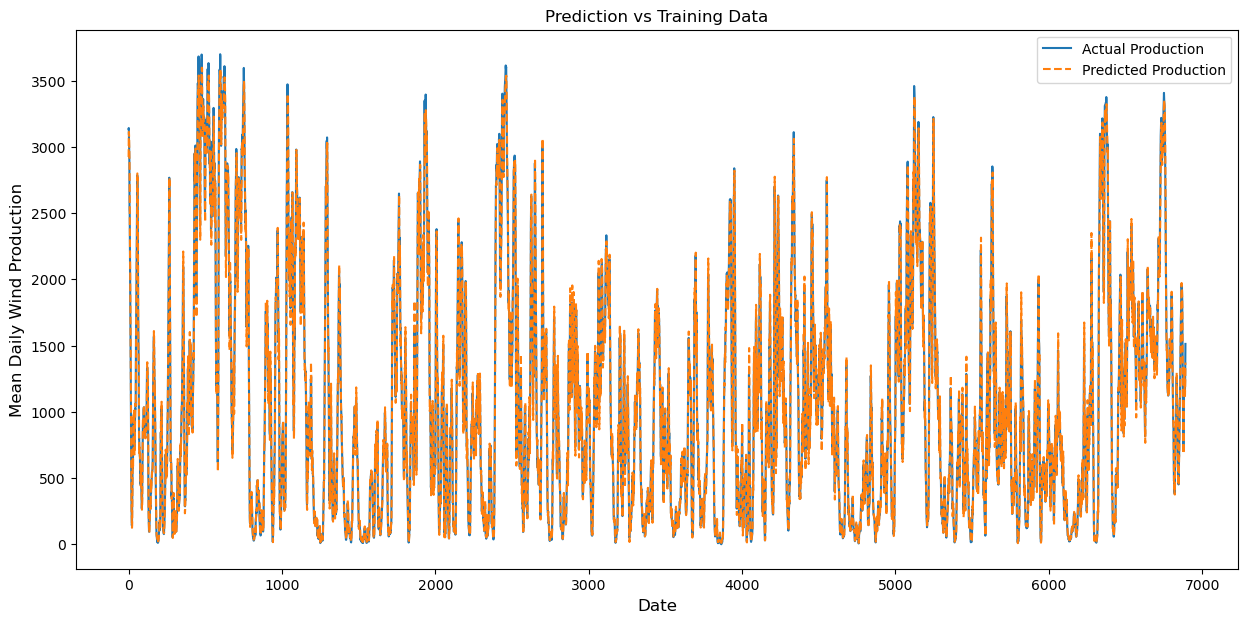

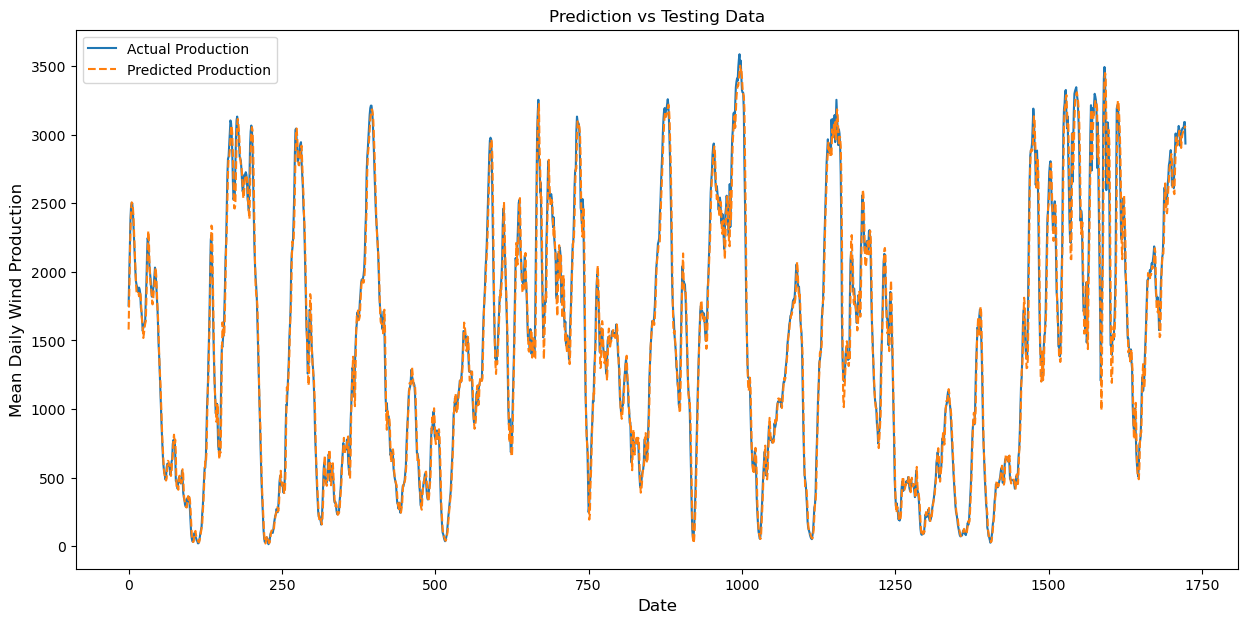

---Train Data---
Root Mean Squared Error: 101.64540606928985
R-squared: 0.9861839362447515
---Test Data---
Root Mean Squared Error: 120.6654115841477
R-squared: 0.9831376704880915


In [104]:
# Plot and evaluate predictions
inverse_transform_and_plot(y_train, predict_train, y_test, predict_test)
